In [191]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import category_encoders as ce

In [192]:
df = pd.read_csv('data/merged4.csv', encoding='latin1', index_col=0)

C:\Users\Patrik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Manually separating static and dynamic attributes
Also remove:
* **future data** = data that might be changed after end of a project's campaign or were not available at the time of the first scraping
* **redundant/duplicate data** = data contained in both datasets
* **useless data** = variables with single value (e.g. for all observations 'spotlight' is False), ids, names, json data, etc

In [193]:
df.info(max_cols=120)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30702 entries, 0 to 30701
Data columns (total 113 columns):
average_pledge                           30702 non-null float64
average_pledge_end                       30702 non-null float64
backers_count                            30702 non-null int64
backers_count_end                        30702 non-null int64
blurb                                    30702 non-null object
blurb_end                                30702 non-null object
category                                 30702 non-null object
category_end                             30702 non-null object
category_name                            30702 non-null object
category_name_end                        30702 non-null object
category_parent                          30702 non-null object
category_parent_end                      30702 non-null object
category_position                        30702 non-null int64
category_position_end                    30702 non-null int64
country   

In [194]:
static_data = []
dynamic_data = []
useless_data = []

### 1. average_pledge

In [195]:
dynamic_data.append('average_pledge')

### 2. average_pledge_end

In [196]:
# future data
useless_data.append('average_pledge_end')

### 3. backers_count

In [197]:
dynamic_data.append('backers_count')

### 4. backers_count_end

In [198]:
# future data
useless_data.append('backers_count_end')

### 5. blurb TODO NLP

In [199]:
static_data.append('blurb')

### 6. blurb_end

In [200]:
# future data
useless_data.append('blurb_end')

### 7. category

In [201]:
df.loc[1,'category']

'{"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/dance/performances"}},"color":10917369,"parent_id":6,"name":"Performances","id":254,"position":1,"slug":"dance/performances"}'

In [202]:
# wrong format, useful data already extracted
useless_data.append('category')

### 8. category_end

In [203]:
# future data
useless_data.append('category_end')

### 9. category_name

In [204]:
static_data.append('category_name')

### 10. category_name_end

In [205]:
# future data
useless_data.append('category_name_end')

### 11. category_parent

In [206]:
static_data.append('category_parent')

### 12. category_parent_end

In [207]:
# future data
useless_data.append('category_parent_end')

### 13. category_position (= position of category in parent category)

In [208]:
df.category_position.value_counts()

4     4103
3     3113
1     2833
2     2588
5     2559
7     2433
10    2024
6     1822
9     1693
14    1381
8     1360
11    1311
12     938
13     751
15     698
18     514
17     260
19     224
16      97
Name: category_position, dtype: int64

In [209]:
# cookbooks are 3rd in category Food (see kickstarter)
df[df.category_name == 'Cookbooks']['category_position'].value_counts()

3    184
Name: category_position, dtype: int64

In [210]:
# only Film & Video parent category contains 19 categories (19th is Webseries)
df[df.category_position == 19]['category_name'].value_counts()

Webseries    224
Name: category_name, dtype: int64

In [211]:
static_data.append('category_position')

### 14. category_position_end

In [212]:
# future data
useless_data.append('category_position_end')

### 15. country

In [213]:
static_data.append('country')

### 16. created_at

In [214]:
# timestamp, already used to extract days_preparation
# not commonly accesible to public on website, therefore should not affect behavior
useless_data.append('created_at')

### 17. creator

In [215]:
df.loc[1, 'creator']

'{"urls":{"web":{"user":"https://www.kickstarter.com/profile/1221271849"},"api":{"user":"https://api.kickstarter.com/v1/users/1221271849?signature=1446480213.130b2f9d9454277a259bf219e9b6dea39bf2ac2f"}},"name":"Cassandra Kemper","id":1221271849,"avatar":{"small":"https://ksr-ugc.imgix.net/avatars/18458965/10513971_562158447259130_1760610303_n.original.jpg?v=1445003326&w=80&h=80&fit=crop&auto=format&q=92&s=2ed4c6c88ff74c2750dbdeae1d34b953","thumb":"https://ksr-ugc.imgix.net/avatars/18458965/10513971_562158447259130_1760610303_n.original.jpg?v=1445003326&w=40&h=40&fit=crop&auto=format&q=92&s=fb2f0e15152b11832b8e80706ce01890","medium":"https://ksr-ugc.imgix.net/avatars/18458965/10513971_562158447259130_1760610303_n.original.jpg?v=1445003326&w=160&h=160&fit=crop&auto=format&q=92&s=043c24006839e18fadfbe74e7a5769a4"}}'

In [216]:
# nothing usefull here, wrong format
useless_data.append('creator')

### 18. creator_end

In [217]:
# nothing usefull here, wrong format
useless_data.append('creator_end')

### 19. creator_name

In [218]:
# useless
useless_data.append('creator_name')

### 20. creator_name_end

In [219]:
# useless
useless_data.append('creator_name_end')

### 21. currency

In [220]:
static_data.append('currency')

### 22. currency_symbol

In [221]:
df.currency_symbol.value_counts()

$      23695
?       6308
kr       544
Fr       155
Name: currency_symbol, dtype: int64

In [222]:
# damaged and redundant data
useless_data.append('currency_symbol')

### 23. currency_trailing_code

In [223]:
# useless
useless_data.append('currency_trailing_code')

### 24. days_duration

In [224]:
static_data.append('days_duration')

### 25. days_preparation

In [225]:
static_data.append('days_preparation')

### 26. days_remaining

In [226]:
dynamic_data.append('days_remaining')

### 27. days_running

In [227]:
dynamic_data.append('days_running')

### 28. db_backers_count

In [228]:
# future data
useless_data.append('db_backers_count')

### 29. db_category_id

In [229]:
# useless (ordinal representation of parent category)
useless_data.append('db_category_id')

### 30. db_comments_count

In [230]:
# future data
useless_data.append('db_comments_count')

### 31. db_creators_url

In [231]:
useless_data.append('db_creators_url')

### 32. db_currency

In [232]:
# damaged redundant data
useless_data.append('db_currency')

### 33. db_description_full TODO NLP + img,video count?

In [233]:
static_data.append('db_description_full')

### 34. db_description_short

In [234]:
df[df['blurb_end'] != df['db_description_short']][['blurb','db_description_short']].sample(5)

,blurb,db_description_short
1713,This free tech program will teach young coders...,This free tech program will teach young coders...
7296,An immersive theatre experience. A speakeasy a...,An immersive theatre experience. A speakeasy a...
24259,"WooD?, Water only on Demand, is a hands-free r...","WooD?, Water only on Demand, is a hands-free r..."
23951,London Burlesque Festival needs your support N...,London Burlesque Festival needs your support N...
27881,"""Everything You Need Is Inside You"" is a enlig...",&quot;Everything You Need Is Inside You&quot; ...


In [235]:
# redundant data
useless_data.append('db_description_short')

### 35. db_duration

In [236]:
# keep due to inconsistency with days_duration
static_data.append('db_duration')

### 36. db_end_time

In [237]:
# useless
useless_data.append('db_end_time')

### 37. db_faq_count

In [238]:
# future data
useless_data.append('db_faq_count')

### 38. db_fb_comments_count

In [239]:
df['db_fb_comments_count'].describe()

count    30702.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: db_fb_comments_count, dtype: float64

In [240]:
# always 0
useless_data.append('db_fb_comments_count')

### 39. db_fb_shares_count TODO estimate

In [241]:
dynamic_data.append('db_fb_shares_count')

### 40. db_goal

In [242]:
len(df[df['goal'] != df['db_goal']])

0

In [243]:
# redundant data
useless_data.append('db_goal')

### 41. db_hours_remaining

In [244]:
# useless data
useless_data.append('db_hours_remaining')

### 42. db_image_url TODO transform

In [245]:
static_data.append('db_image_url')

### 43. db_location_id

In [246]:
len(df['db_location_id'].value_counts())

5139

In [247]:
# useless (ordinal representation of other columns)
useless_data.append('db_location_id')

### 44. db_name

In [248]:
# useless
useless_data.append('db_name')

### 45. db_pledged

In [249]:
# future data
useless_data.append('db_pledged')

### 46. db_project_data

In [250]:
# usefull data already extracted
useless_data.append('db_project_data')

### 47. db_project_id

In [251]:
# useless
useless_data.append('db_project_id')

### 48. db_project_we_love

In [252]:
# future data
useless_data.append('db_project_we_love')

### 49. db_start_time

In [253]:
# useless
useless_data.append('db_start_time')

### 50. db_status

In [254]:
# useless, we use our own classes
useless_data.append('db_status')

### 51. db_subcategory_id

In [255]:
# ordinal representation of category_name
useless_data.append('db_subcategory_id')

### 52. db_updates_count

In [256]:
# future data
useless_data.append('db_updates_count')

### 53. db_url

In [257]:
# useless
useless_data.append('db_url')

### 54. db_video_url TODO transform

In [258]:
static_data.append('db_video_url')

### 55. deadline_end  TODO extract features (+ add analysis)

In [259]:
# already used to extract days_duration and days_remaining
static_data.append('deadline_end')

### 56. disable_communication

In [260]:
df['disable_communication'].describe()

count     30702
unique        1
top       False
freq      30702
Name: disable_communication, dtype: object

In [261]:
# always False
useless_data.append('disable_communication')

### 57. disable_communication_end

In [262]:
# future data
useless_data.append('disable_communication_end')

### 58. goal

In [263]:
static_data.append('goal')

### 59. id

In [264]:
# useless
useless_data.append('id')

### 60. launched_at  TODO extract features (+ add analysis)

In [265]:
# already used to extract days_preparation and days_running
static_data.append('launched_at')

### 61. location

In [266]:
# already used to extract data
useless_data.append('location')

### 62. location_end

In [267]:
# future data
useless_data.append('location_end')

### 63. location_is_root

In [268]:
df.location_is_root.describe()

count     30702
unique        1
top       False
freq      30702
Name: location_is_root, dtype: object

In [269]:
# always False
useless_data.append('location_is_root')

### 64. location_name

In [270]:
static_data.append('location_name')

### 65. location_name_end

In [271]:
# future data
useless_data.append('location_name_end')

### 66. location_state

In [272]:
static_data.append('location_state')

### 67. location_state_end

In [273]:
# future data
useless_data.append('location_state_end')

### 68. location_type

In [274]:
static_data.append('location_type')

### 69. location_type_end

In [275]:
# future data
useless_data.append('location_type_end')

### 70. name

In [276]:
# useless
useless_data.append('name')

### 71. name_end

In [277]:
# useless
useless_data.append('name_end')

### 72. photo

In [278]:
df.loc[1,'photo']

'{"small":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=160&h=120&fit=crop&auto=format&q=92&s=024364bb83f379e11d0ef29eafd2bb3a","1536x1152":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1536&h=1152&fit=crop&auto=format&q=92&s=30664a3df037a1672f4cd849f298ed5a","thumb":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=40&h=30&fit=crop&auto=format&q=92&s=5556d33ffad29a3ff8f0e676a0ebeaeb","1024x768":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1024&h=768&fit=crop&auto=format&q=92&s=0baef5145af0d44caaebdffcecad8709","med":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=266&h=200&fit=crop&auto=format&q=92&s=0e6f16d2bc45ce1925bc6661c340ced2","key":"projects/2137299/photo-original.jpg","ed":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=338&h=250&fit=crop&auto=format&q=92&s=f323d7eb379b5b563b9ef7e262fda6cd","fu

In [279]:
# wrong format, describes only 1 photo - redundant data
useless_data.append('photo')

### 73. photo_end

In [280]:
# useless, redundant
useless_data.append('photo_end')

### 74. pledged

In [281]:
dynamic_data.append('pledged')

### 75. pledged_end

In [282]:
# future data
useless_data.append('pledged_end')

### 76. profile

In [283]:
df.loc[1, 'profile']

'{"background_image_opacity":0.8,"link_text_color":null,"state_changed_at":1444938006,"should_show_feature_image":true,"blurb":null,"background_color":null,"project_id":2176873,"name":null,"feature_image_attributes":{"image_urls":{"default":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1536&h=1152&fit=crop&auto=format&q=92&s=30664a3df037a1672f4cd849f298ed5a","baseball_card":"https://ksr-ugc.imgix.net/projects/2137299/photo-original.jpg?v=1444938200&w=1536&h=1152&fit=crop&auto=format&q=92&s=30664a3df037a1672f4cd849f298ed5a"}},"link_url":null,"show_feature_image":false,"id":2176873,"state":"inactive","text_color":null,"link_text":null,"link_background_color":null}'

In [284]:
# wrong format, useless
useless_data.append('profile')

### 77. profile_end

In [285]:
# future data
useless_data.append('profile_end')

### 78. ratio_pledged_end_goal

In [286]:
# already used to extract class
useless_data.append('ratio_pledged_end_goal')

### 79. ratio_pledged_goal

In [287]:
dynamic_data.append('ratio_pledged_goal')

### 80. ratio_running_duration

In [288]:
dynamic_data.append('ratio_running_duration')

### 81. scraped_at

In [289]:
# already used to extract many features
useless_data.append('scraped_at')

### 82. slug

In [290]:
# useless
useless_data.append('slug')

### 83. source_url

In [291]:
# useless
useless_data.append('source_url')

### 84. source_url_end

In [292]:
# useless
useless_data.append('source_url_end')

### 85. spotlight

In [293]:
df.spotlight.describe()

count     30702
unique        1
top       False
freq      30702
Name: spotlight, dtype: object

In [294]:
# always False
useless_data.append('spotlight')

### 86. spotlight_end

In [295]:
# future data
useless_data.append('spotlight_end')

### 87. staff_pick

In [296]:
dynamic_data.append('staff_pick')

### 88. staff_pick_end

In [297]:
# future data
useless_data.append('staff_pick_end')

### 89. state

In [298]:
df.state.describe()

count     30702
unique        1
top        live
freq      30702
Name: state, dtype: object

In [299]:
# always live
useless_data.append('state')

### 90. state_changed_at

In [300]:
# useless
useless_data.append('state_changed_at')

### 91. state_changed_at_end

In [301]:
# useless, future data
useless_data.append('state_changed_at_end')

### 92. state_end

In [302]:
# future data, we have our own prediction class
useless_data.append('state_end')

### 93. static_usd_rate

In [303]:
# already used for currency conversion to USD
useless_data.append('static_usd_rate')

### 94. static_usd_rate_end

In [304]:
# useless, future data
useless_data.append('static_usd_rate_end')

### 95. url_name

In [305]:
# useless
useless_data.append('url_name')

### 96. urls

In [306]:
df.loc[1, 'urls']

'{"web":{"project":"https://www.kickstarter.com/projects/1221271849/all-style-dance-battle-the-streak?ref=category","rewards":"https://www.kickstarter.com/projects/1221271849/all-style-dance-battle-the-streak/rewards"}}'

In [307]:
# useless
useless_data.append('urls')

### 97. urls_end

In [308]:
# useless
useless_data.append('urls_end')

### 98. urls_url

In [309]:
# useless
useless_data.append('urls_url')

### 99. urls_url_end

In [310]:
# useless
useless_data.append('urls_url_end')

### 100. usd_goal

In [311]:
static_data.append('usd_goal')

### 101. usd_pledged

In [312]:
dynamic_data.append('usd_pledged')

### 102. usd_pledged_end

In [313]:
# future data
useless_data.append('usd_pledged_end')

### 103. class

In [314]:
# predicted class
static_data.append('class')

### 104. ID

In [315]:
# useless
useless_data.append('ID')

### 105. faq_count_while_scraping

In [316]:
dynamic_data.append('faq_count_while_scraping')

### 106. comments_count_creator_while_scraping

In [317]:
dynamic_data.append('comments_count_creator_while_scraping')

### 107. comments_count_public_while_scraping

In [318]:
dynamic_data.append('comments_count_public_while_scraping')

### 108. updates_count_while_scraping

In [319]:
dynamic_data.append('updates_count_while_scraping')

### 109. updates_likes_sum_while_scraping

In [320]:
dynamic_data.append('updates_likes_sum_while_scraping')

### 110. updates_likes_mean_while_scraping

In [321]:
dynamic_data.append('updates_likes_mean_while_scraping')

### 111. updates_likes_min_while_scraping

In [322]:
dynamic_data.append('updates_likes_min_while_scraping')

### 112. updates_likes_max_while_scraping

In [323]:
dynamic_data.append('updates_likes_max_while_scraping')

### 113. updates_likes_median_while_scraping

In [324]:
dynamic_data.append('updates_likes_median_while_scraping')

In [325]:
len(static_data)

20

In [326]:
len(dynamic_data)

19

In [327]:
len(useless_data)

74

In [328]:
static_data

['blurb',
 'category_name',
 'category_parent',
 'category_position',
 'country',
 'currency',
 'days_duration',
 'days_preparation',
 'db_description_full',
 'db_duration',
 'db_image_url',
 'db_video_url',
 'deadline_end',
 'goal',
 'launched_at',
 'location_name',
 'location_state',
 'location_type',
 'usd_goal',
 'class']

In [329]:
dynamic_data

['average_pledge',
 'backers_count',
 'days_remaining',
 'days_running',
 'db_fb_shares_count',
 'pledged',
 'ratio_pledged_goal',
 'ratio_running_duration',
 'staff_pick',
 'usd_pledged',
 'faq_count_while_scraping',
 'comments_count_creator_while_scraping',
 'comments_count_public_while_scraping',
 'updates_count_while_scraping',
 'updates_likes_sum_while_scraping',
 'updates_likes_mean_while_scraping',
 'updates_likes_min_while_scraping',
 'updates_likes_max_while_scraping',
 'updates_likes_median_while_scraping']

In [330]:
df_selected = df.drop(useless_data, axis=1)

In [331]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30702 entries, 0 to 30701
Data columns (total 39 columns):
average_pledge                           30702 non-null float64
backers_count                            30702 non-null int64
blurb                                    30702 non-null object
category_name                            30702 non-null object
category_parent                          30702 non-null object
category_position                        30702 non-null int64
country                                  30702 non-null object
currency                                 30702 non-null object
days_duration                            30702 non-null int64
days_preparation                         30702 non-null int64
days_remaining                           30702 non-null int64
days_running                             30702 non-null int64
db_description_full                      30691 non-null object
db_duration                              30702 non-null int64
db_fb_shares_co

In [332]:
df_selected.to_csv('data/selected_data.csv')

# Data pre-processing

## Sampling

## Outlier detection

## Missing values resolution

In [333]:
df[static_data].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30702 entries, 0 to 30701
Data columns (total 20 columns):
blurb                  30702 non-null object
category_name          30702 non-null object
category_parent        30702 non-null object
category_position      30702 non-null int64
country                30702 non-null object
currency               30702 non-null object
days_duration          30702 non-null int64
days_preparation       30702 non-null int64
db_description_full    30691 non-null object
db_duration            30702 non-null int64
db_image_url           21414 non-null object
db_video_url           20443 non-null object
deadline_end           30702 non-null int64
goal                   30702 non-null float64
launched_at            30702 non-null int64
location_name          30702 non-null object
location_state         30695 non-null object
location_type          30702 non-null object
usd_goal               30702 non-null int64
class                  30702 non-null int6

In [334]:
df[df['location_state'].isnull()][['url_name', 'location_name', 'location_state', 'location_type', 'country']]

,url_name,location_name,location_state,location_type,country
3054,the-white-desert-wildlife-and-antarctica-photo...,Antarctica,NaN,Country,US
7903,music-video-makedonsko-devojce-jazz-version,Skopje,NaN,Town,DE
16683,oualichi-gold-caribbean-erotica,Philipsburg,NaN,Town,US
21286,new-album-kickstarter,Road Town,NaN,Town,US
30232,baby-chef-cookbook-and-app-with-healthy-recipe...,Skopje,NaN,Town,AU
30347,ninos-otomies-le-cantan-al-papa-francisco,Vatican City,NaN,Town,MX
30389,portraits-of-place-in-antarctica-ii,Antarctica,NaN,Country,US


In [335]:
df.loc[3054, 'location_state'] = 'None'
df.loc[7903, 'location_state'] = 'Macedonia'
df.loc[16683, 'location_state'] = 'Sint Maarten (Dutch part)'
df.loc[21286, 'location_state'] = 'Virgin Islands, U.S. '
df.loc[30232, 'location_state'] = 'Macedonia'
df.loc[30347, 'location_state'] = 'Vatican City'
df.loc[30389, 'location_state'] = 'None'

In [336]:
df[df['location_state'].isnull()][['url_name', 'location_name', 'location_state', 'location_type', 'country']]

,url_name,location_name,location_state,location_type,country


# Feature engineering

## Feature extraction

### 1. deadline

In [337]:
# convert unix timestamp to datetime of scraping
df['deadline_datetime'] = pd.to_datetime(df['deadline_end'], unit='s')
df[['url_name','deadline_end','deadline_datetime', 'db_end_time']].sample(5)

,url_name,deadline_end,deadline_datetime,db_end_time
8138,pizza-one,1465033928,2016-06-04 09:52:08,2016-06-04
25523,disappearing-trees-of-roath-photography-zine,1495234740,2017-05-19 22:59:00,2017-05-19
25988,oni-x-fox-volume-1-soldier-daze-printed-edition,1495726895,2017-05-25 15:41:35,2017-05-25
3798,chrissys-cruisin-creations,1458584717,2016-03-21 18:25:17,2016-03-21
5476,flintlock-book-1,1459495329,2016-04-01 07:22:09,2016-04-01


#### 1.1 year

In [338]:
df['deadline_year'] = df['deadline_datetime'].dt.year

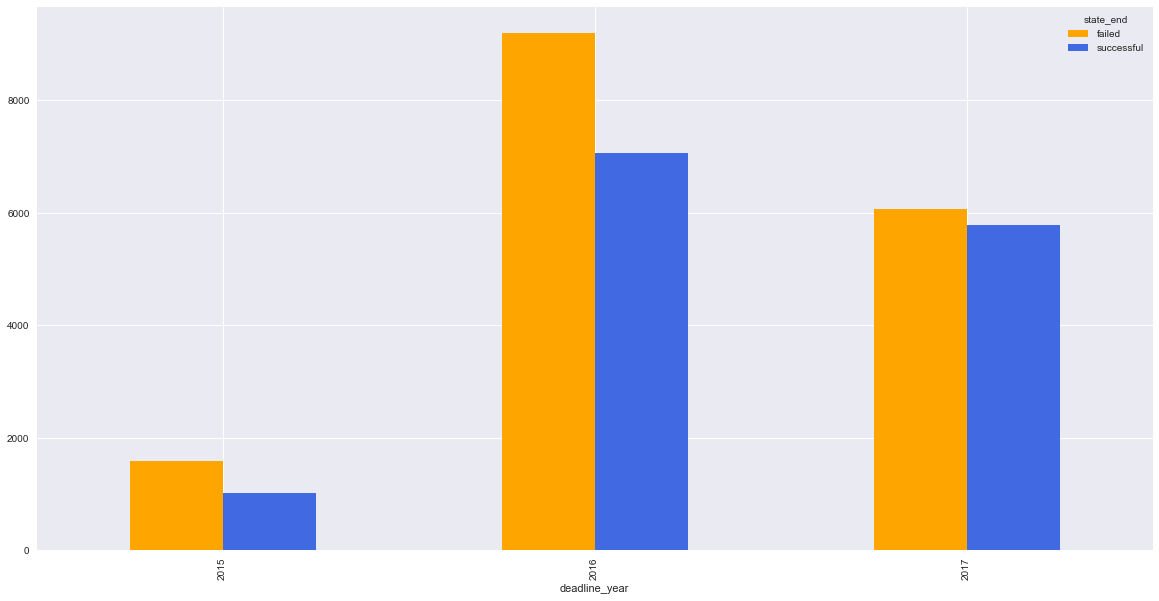

In [339]:
pd.crosstab(index=df['deadline_year'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.2 month

In [340]:
df['deadline_month'] = df['deadline_datetime'].dt.month

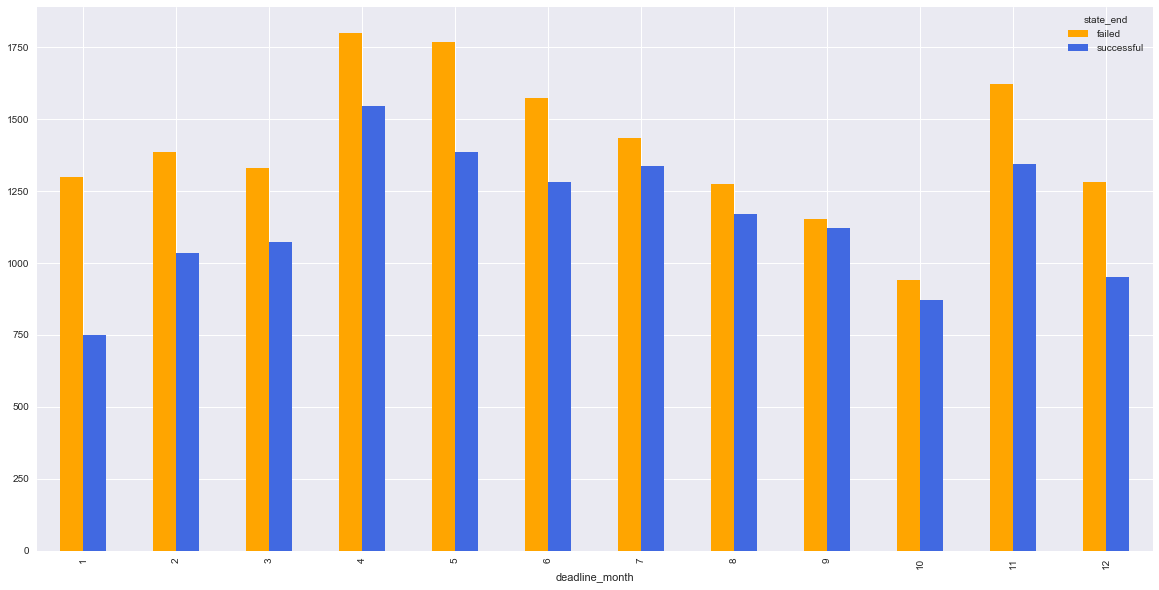

In [341]:
pd.crosstab(index=df['deadline_month'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.3 day

In [342]:
df['deadline_day'] = df['deadline_datetime'].dt.day

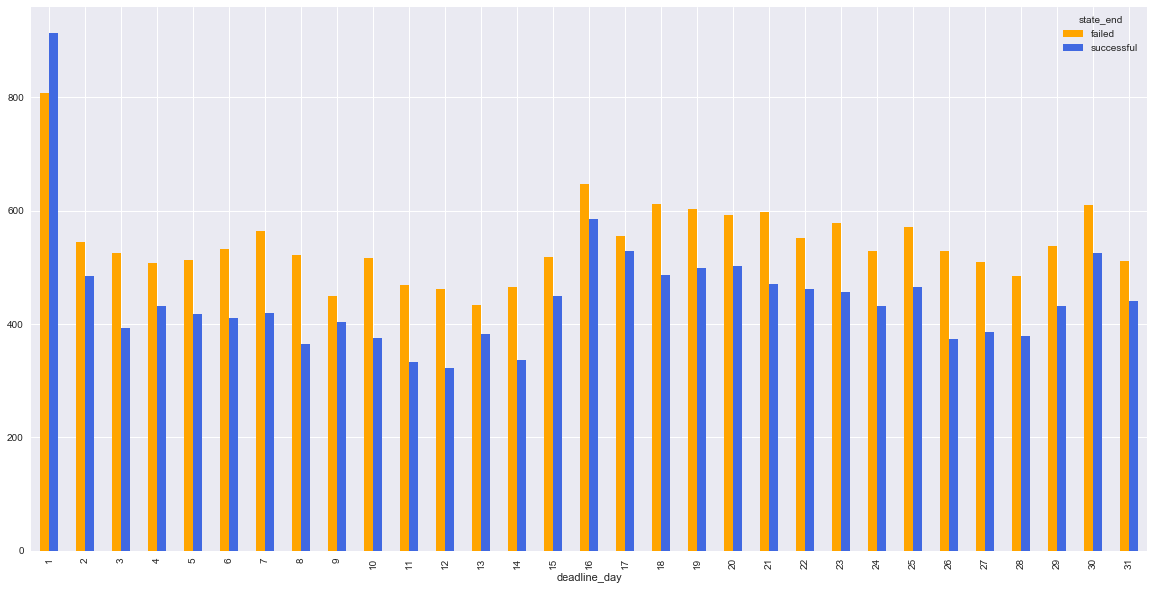

In [343]:
pd.crosstab(index=df['deadline_day'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.4 day of week

In [344]:
df['deadline_dayofweek'] = df['deadline_datetime'].dt.dayofweek

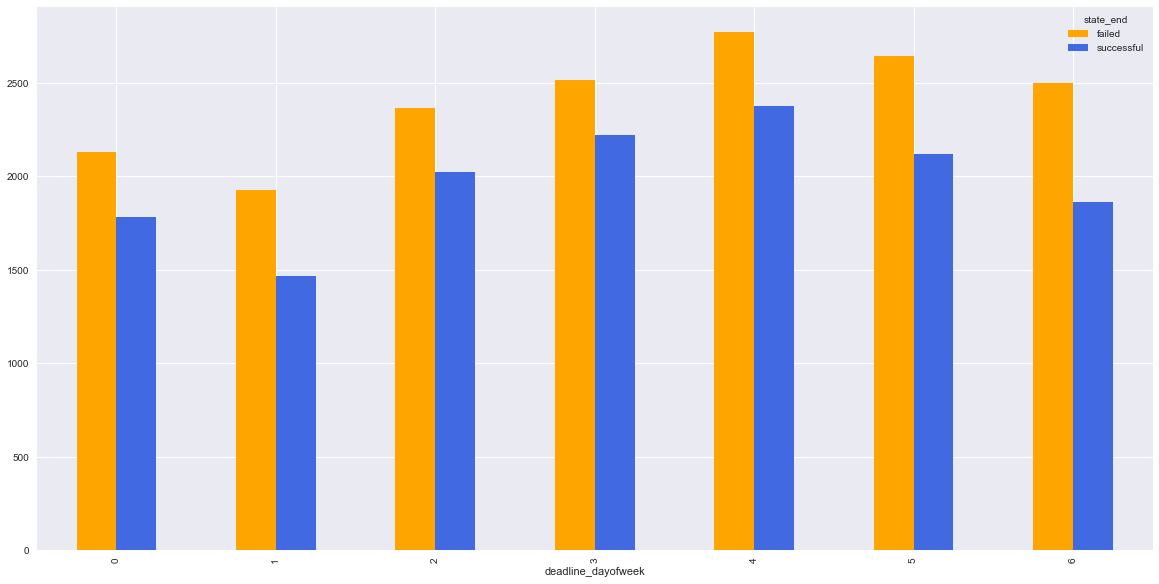

In [345]:
pd.crosstab(index=df['deadline_dayofweek'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 1.5 hour

In [346]:
df['deadline_hour'] = df['deadline_datetime'].dt.hour

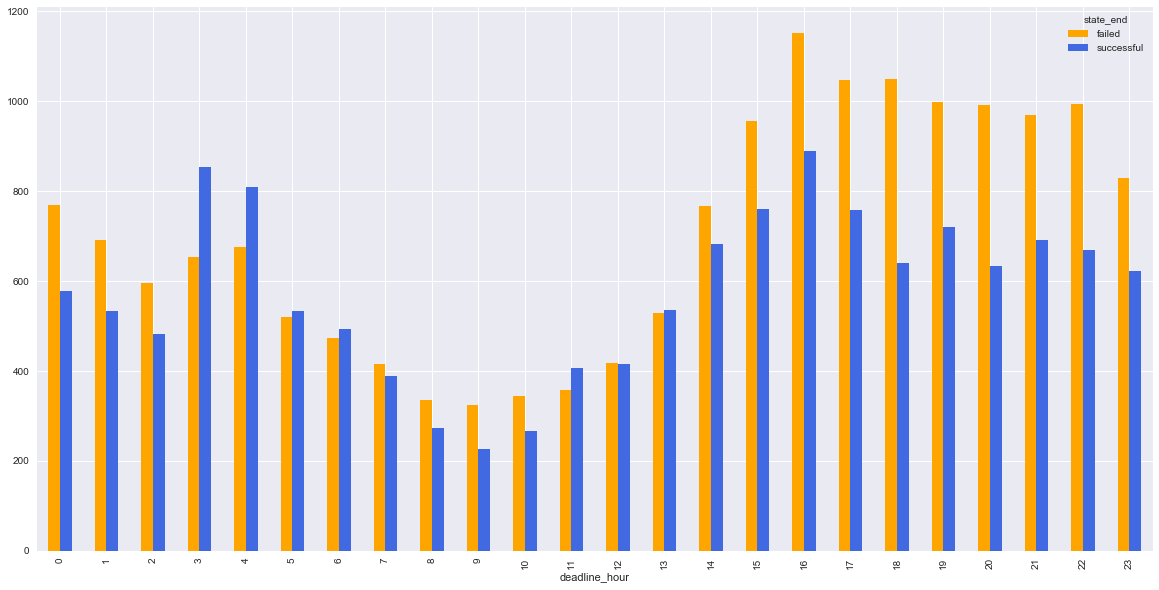

In [347]:
pd.crosstab(index=df['deadline_hour'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

### 2. start

In [348]:
# convert unix timestamp to datetime
df['launch_datetime'] = pd.to_datetime(df['launched_at'], unit='s')
df[['url_name','launched_at','launch_datetime', 'db_start_time']].sample(5)

,url_name,launched_at,launch_datetime,db_start_time
21832,resist-10-piece-sticker-pack,1486162654,2017-02-03 22:57:34,NaN
8179,jay-and-pluto,1460652807,2016-04-14 16:53:27,2016-04-14
6220,redneck-outback-organic-smoking-wood,1456961664,2016-03-02 23:34:24,NaN
5452,cuddlybuddie,1456199879,2016-02-23 03:57:59,NaN
17211,the-float-lodge-duluths-first-premiere-float-c...,1475760567,2016-10-06 13:29:27,NaN


#### 2.1 year

In [349]:
df['launch_year'] = df['launch_datetime'].dt.year

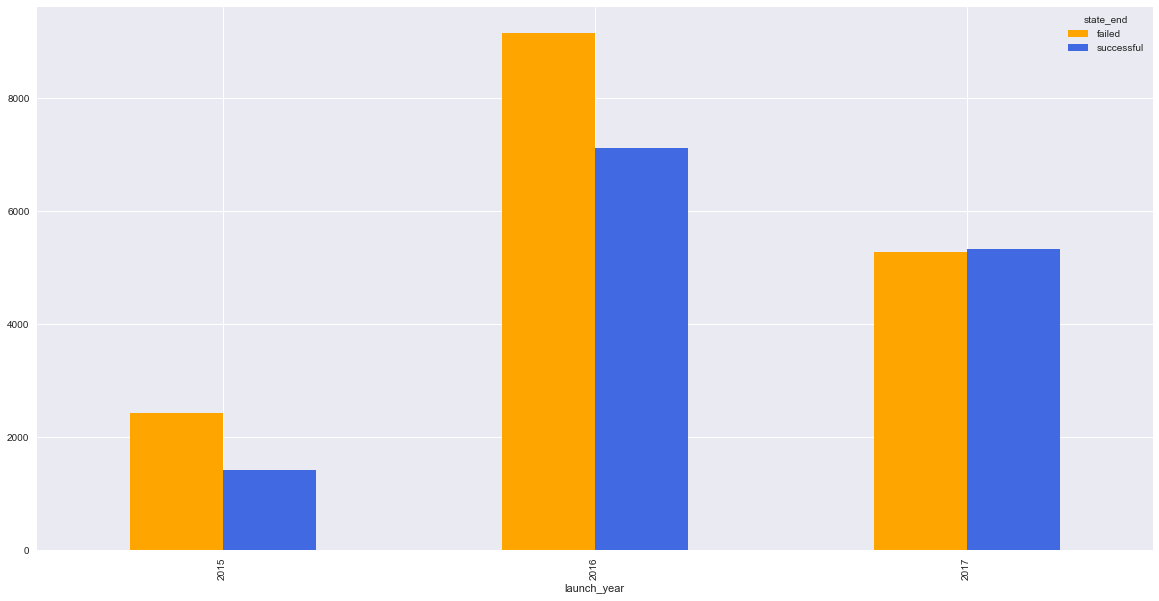

In [350]:
pd.crosstab(index=df['launch_year'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.2 month

In [351]:
df['launch_month'] = df['launch_datetime'].dt.month

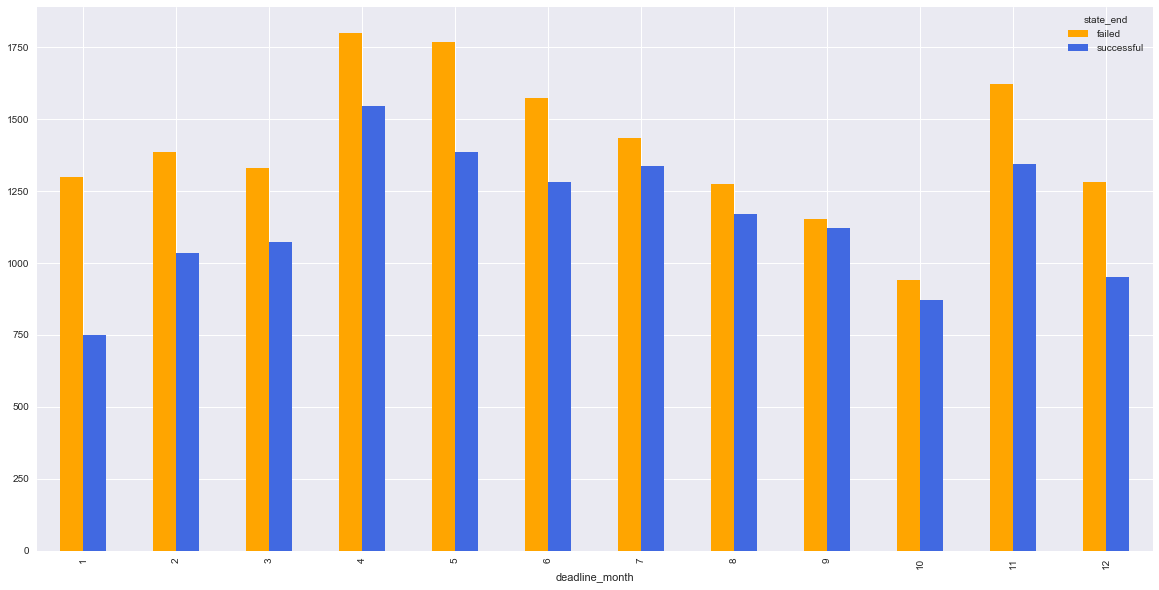

In [352]:
pd.crosstab(index=df['deadline_month'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.3 day

In [353]:
df['launch_day'] = df['launch_datetime'].dt.day

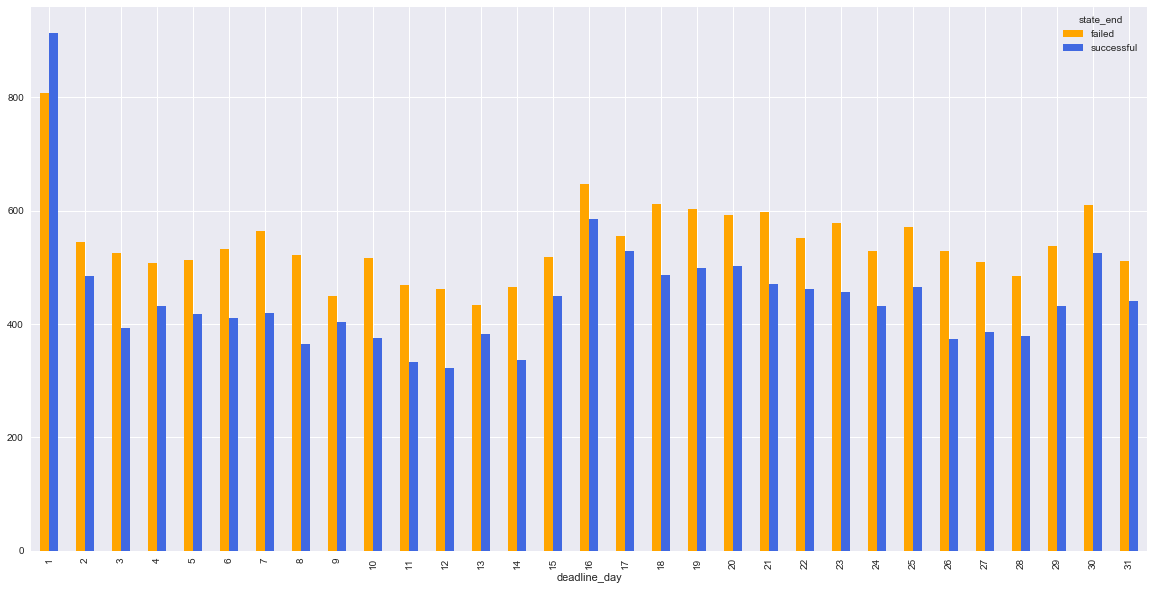

In [354]:
pd.crosstab(index=df['deadline_day'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.4 day of week

In [355]:
df['launch_dayofweek'] = df['launch_datetime'].dt.dayofweek

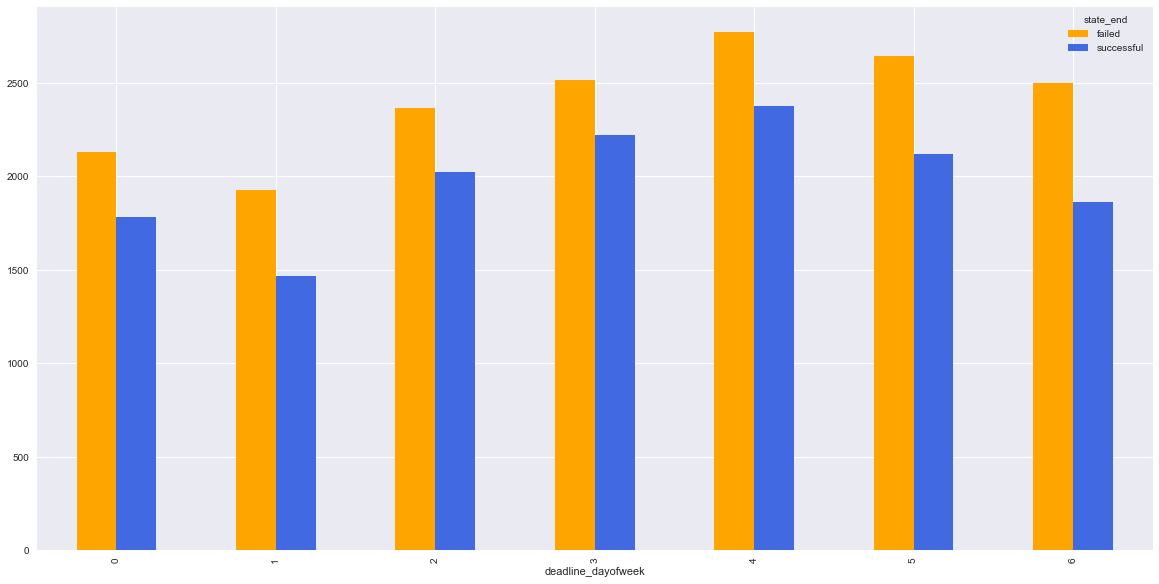

In [356]:
pd.crosstab(index=df['deadline_dayofweek'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

#### 2.5 hour

In [357]:
df['launch_hour'] = df['launch_datetime'].dt.hour

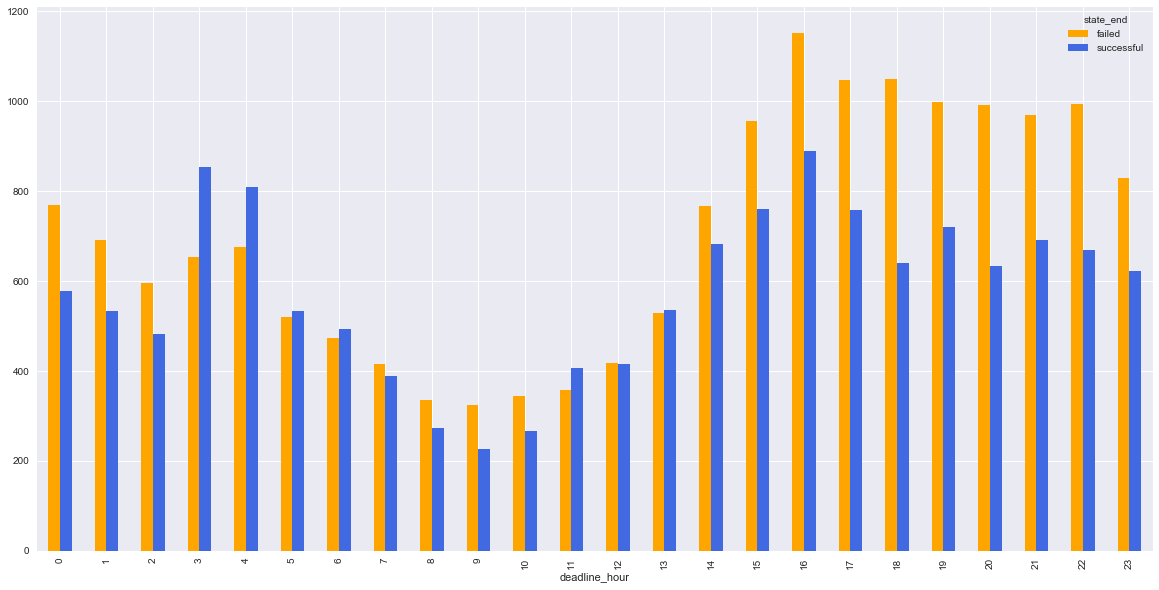

In [358]:
pd.crosstab(index=df['deadline_hour'], columns=df['state_end']).plot.bar(stacked=False, color=['orange', 'royalblue'], figsize=(20,10))

### 3. facebook shares

In [359]:
plt.rcParams['figure.figsize'] = (20,10)

In [360]:
df['db_fb_shares_count'].describe()

count     30702.000000
mean        382.737411
std        1825.706968
min           0.000000
25%           9.000000
50%          77.000000
75%         290.000000
max      108071.000000
Name: db_fb_shares_count, dtype: float64

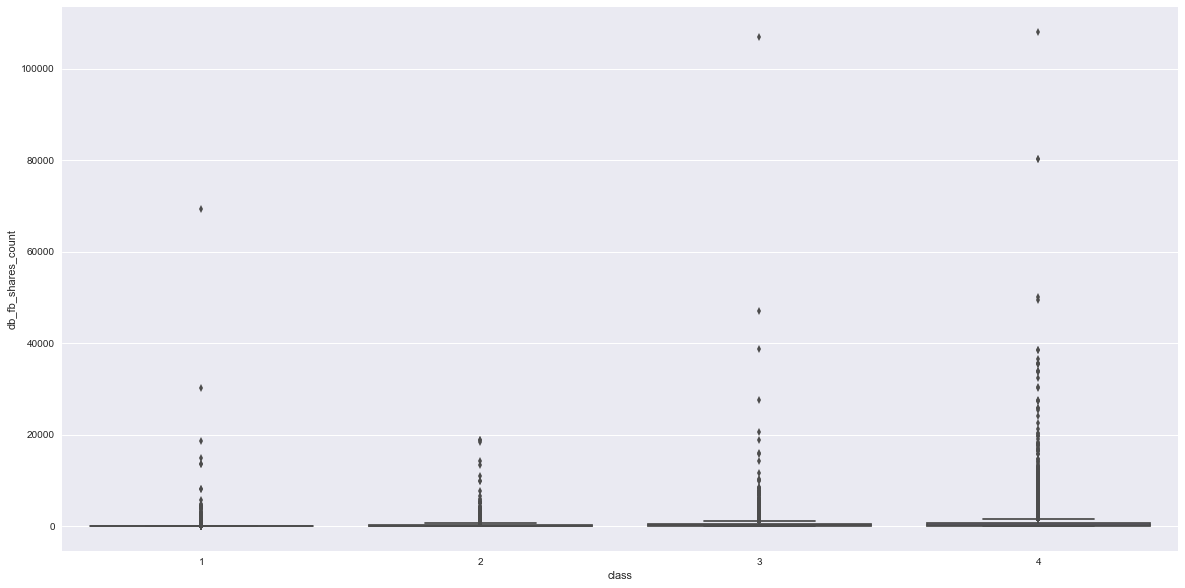

In [361]:
sns.boxplot(data=df, y='db_fb_shares_count', x='class')

(-100, 1600)

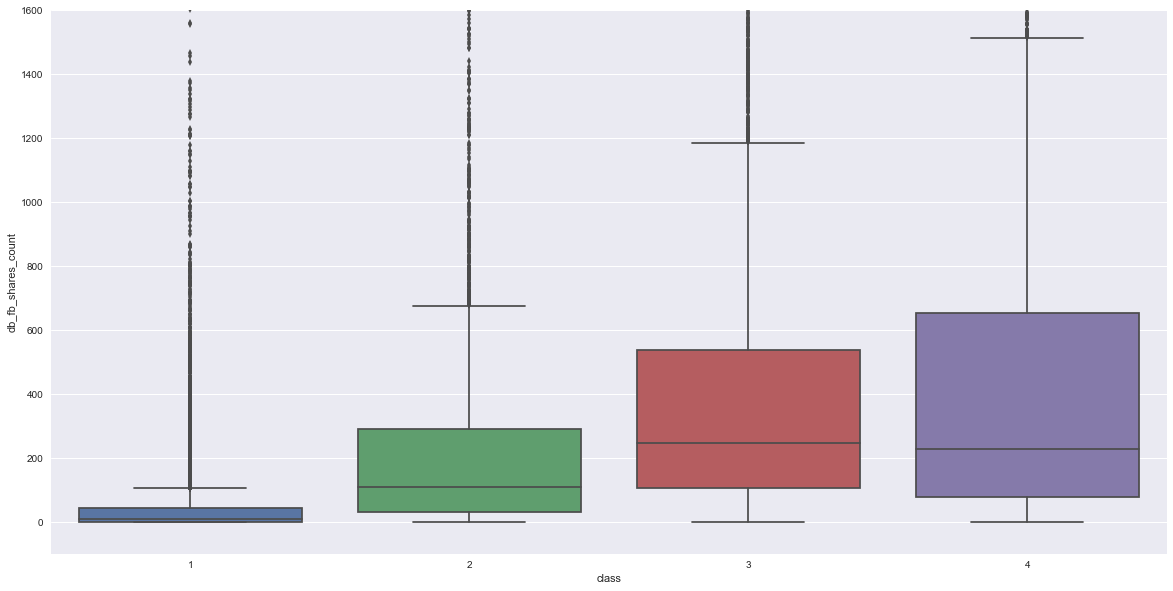

In [362]:
sns.boxplot(data=df, y='db_fb_shares_count', x='class')
plt.ylim((-100,1600))

In [363]:
df.corr()['db_fb_shares_count'].abs().sort_values(ascending=False)

db_fb_shares_count                       1.000000
usd_pledged_end                          0.532433
pledged_end                              0.476600
db_pledged                               0.476600
usd_pledged                              0.475299
backers_count_end                        0.455001
pledged                                  0.435585
db_comments_count                        0.425622
backers_count                            0.415224
updates_likes_max_while_scraping         0.363069
updates_likes_sum_while_scraping         0.359394
updates_likes_mean_while_scraping        0.352924
updates_likes_median_while_scraping      0.343648
comments_count_public_while_scraping     0.336174
comments_count_creator_while_scraping    0.316102
updates_likes_min_while_scraping         0.286362
db_faq_count                             0.263134
ratio_pledged_end_goal                   0.239336
db_updates_count                         0.236754
faq_count_while_scraping                 0.232721


Pearson correlation: 0.532


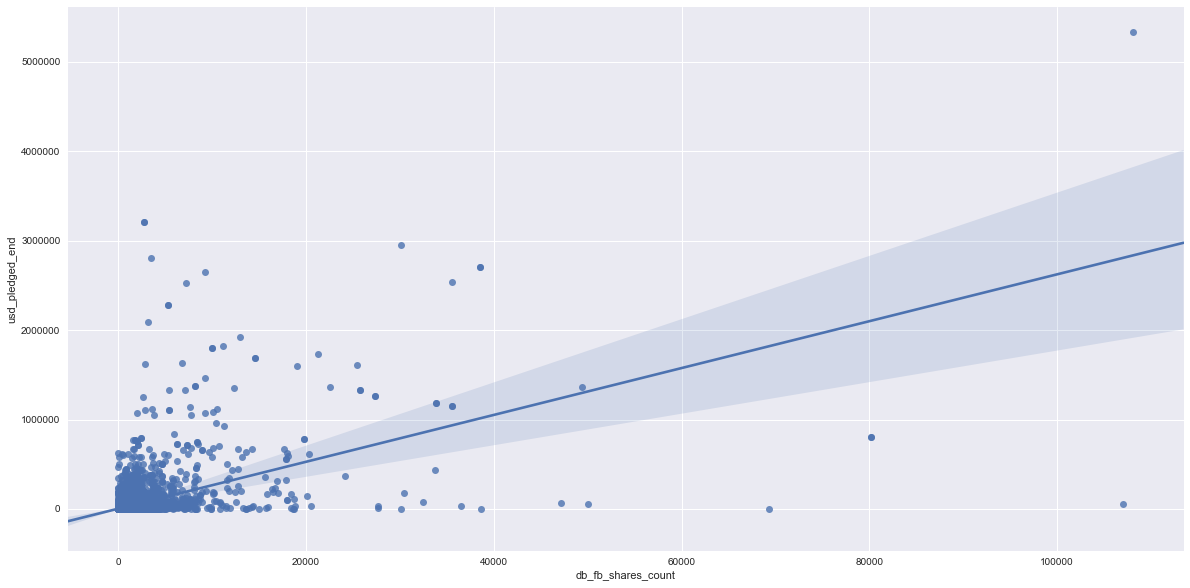

In [364]:
attr = 'usd_pledged_end' 
sns.regplot(x="db_fb_shares_count", y=attr, data=df)
print("Pearson correlation: %.3f" % df['db_fb_shares_count'].corr(df[attr]))

In [365]:
df[df.db_fb_shares_count > 60000]['url_name']

8859           udoo-x86-the-most-powerful-maker-board-ever
8860           udoo-x86-the-most-powerful-maker-board-ever
18063                      scream-a-new-beginning-fan-film
19863          tenkiv-nexus-solving-the-clean-water-crisis
23745    zetime-worlds-first-smartwatch-with-hands-over...
Name: url_name, dtype: object

## Feature transformation

### 1. db_image_url

Transform as follows:
* 0 where url is missing
* 1 otherwise

In [366]:
df.db_image_url.describe()

count                                                 21414
unique                                                18820
top       https://ksr-ugc.imgix.net/assets/011/222/877/1...
freq                                                      3
Name: db_image_url, dtype: object

In [367]:
df.db_image_url.fillna(0, inplace=True)

In [368]:
df.db_image_url = df.db_image_url.apply(lambda x: int(len(str(x)) > 1))

In [369]:
df.rename(index=str, columns={"db_image_url": "db_image"}, inplace=True)

In [370]:
df.db_image.value_counts()

1    21414
0     9288
Name: db_image, dtype: int64

In [371]:
static_data.remove('db_image_url')
static_data.append('db_image')

### 2. db_video_url

Transform as follows:
* 0 where url is missing
* 1 otherwise

In [372]:
df.db_video_url.describe()

count                                                 20443
unique                                                17985
top       https://ksr-video.imgix.net/projects/2639323/v...
freq                                                      3
Name: db_video_url, dtype: object

In [373]:
df.db_video_url.fillna(0, inplace=True)

In [374]:
df.db_video_url = df.db_video_url.apply(lambda x: int(len(str(x)) > 1))

In [375]:
df.rename(index=str, columns={"db_video_url": "db_video"}, inplace=True)

In [376]:
df.db_video.value_counts()

1    20443
0    10259
Name: db_video, dtype: int64

In [377]:
static_data.remove('db_video_url')
static_data.append('db_video')

### 3. Categorical encoding

In [378]:
df[static_data].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30702 entries, 0 to 30701
Data columns (total 20 columns):
blurb                  30702 non-null object
category_name          30702 non-null object
category_parent        30702 non-null object
category_position      30702 non-null int64
country                30702 non-null object
currency               30702 non-null object
days_duration          30702 non-null int64
days_preparation       30702 non-null int64
db_description_full    30691 non-null object
db_duration            30702 non-null int64
deadline_end           30702 non-null int64
goal                   30702 non-null float64
launched_at            30702 non-null int64
location_name          30702 non-null object
location_state         30702 non-null object
location_type          30702 non-null object
usd_goal               30702 non-null int64
class                  30702 non-null int64
db_image               30702 non-null int64
db_video               30702 non-null int64
dtype

In [385]:
data_to_encode = [
    'category_name',
    'category_parent',
    'country',
    'currency',
    'location_name',
    'location_state',
    'location_type',
]
encoded = []

In [386]:
for column in data_to_encode:
    print(column, len(df[column].value_counts()), 'distinct values')
    encoder = ce.OrdinalEncoder()
    df[column+'_num'] = encoder.fit_transform(df[[column]])
    encoded.append(column+'_num')

In [407]:
enc = preprocessing.OneHotEncoder()
enc.fit(df[encoded])

# count of distinct values per each column
enc.n_values_

array([ 141,   15,   22,   14, 4705,  609,    9])

In [408]:
# index borders
enc.feature_indices_

array([   0,  141,  156,  178,  192, 4897, 5506, 5515], dtype=int32)

In [419]:
df_encoded_categorical = pd.DataFrame(enc.transform(df[encoded]).toarray())
df_encoded_categorical.head()

,0,1,2,3,4,5,6,7,8,9,...,5505,5506,5507,5508,5509,5510,5511,5512,5513,5514
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Feature selection

apply PCA to df_encoded_categorical or its subparts?

vs. to whole feature vector?

In [403]:
df[static_data].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30702 entries, 0 to 30701
Data columns (total 20 columns):
blurb                  30702 non-null object
category_name          30702 non-null object
category_parent        30702 non-null object
category_position      30702 non-null int64
country                30702 non-null object
currency               30702 non-null object
days_duration          30702 non-null int64
days_preparation       30702 non-null int64
db_description_full    30691 non-null object
db_duration            30702 non-null int64
deadline_end           30702 non-null int64
goal                   30702 non-null float64
launched_at            30702 non-null int64
location_name          30702 non-null object
location_state         30702 non-null object
location_type          30702 non-null object
usd_goal               30702 non-null int64
class                  30702 non-null int64
db_image               30702 non-null int64
db_video               30702 non-null int64
dtype

In [414]:
df_static = df[static_data].select_dtypes(exclude=['object']).drop(['deadline_end', 'launched_at'], axis=1)

In [434]:
# change index types
df_encoded_categorical.index = df_encoded_categorical.index.astype('int64')
df_static.index = df_static.index.astype('int64')

In [441]:
df_static = df_static.join(df_encoded_categorical)

In [442]:
df_static.to_csv('data/static_01.csv')